* [1. Aprendizado de todos os Modelos X Todos os tipos de recompensa](#0)
* [2. Predição de todos os Modelos X Todos os tipos de recompensa](#1)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import os
import gym
from gym.utils import seeding
from gym import spaces
import numpy as np
import numpy.random as rd
from stockstats import StockDataFrame as Sdf
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import logger
import base64
from pathlib import Path
from IPython.display import display, HTML
from IPython import display as ipythondisplay
from copy import copy
import ta
from ta.trend import PSARIndicator, SMAIndicator, MACD, CCIIndicator, ADXIndicator
from ta.volume import MFIIndicator
from ta.momentum import RSIIndicator, StochRSIIndicator

In [2]:
class SimpleCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(SimpleCallback, self).__init__(verbose)
        self._called = False
    
    def _on_step(self):
        print("\rNum timesteps: {}".format(self.num_timesteps), end = "")

        return True # returns True, training continues.

In [3]:
def data_split(df, start, end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.date >= start) & (df.date < end)]
    data = data.sort_values(["date"], ignore_index=True)
    data.index = data.date.factorize()[0]
    return data

In [4]:
def LearnModel(Model, 
               df ,
               initial_account = 1e6 ,
               reward_low = -1 ,  
               reward_high = 0.1 , 
               reward_tipo = 'spot', # 'mfi' ou 'spot' ou 'rsi' 
               total_timesteps = 10000, 
               verbose = False): 
    
    def Models(Model):
        MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
        return MODELS[Model]
    
    def Params(Model,env):
        PARAMS = {"a2c":{
                        'env': env,
                        "policy":"MlpPolicy",    
                        "n_steps": 5, 
                        "ent_coef": 0.005, 
                        "learning_rate": 0.0002,
                        "device": 'cuda',
                        "verbose": 0,
                        '_init_setup_model': True,
                        'seed': 1024
                        },
                  "ddpg": {
                        'env': env,
                        "policy":"MlpPolicy",    
                        "batch_size": 64, 
                        "buffer_size": 500000, 
                        "learning_rate": 0.0001,
                        "device": 'cuda',
                        "verbose": 0,
                        '_init_setup_model': True,
                        'seed': 1024    
                        }, 
                  "td3": {
                        'env': env,
                        "policy":"MlpPolicy",    
                        "batch_size": 128,
                        "buffer_size": 1000000, 
                        "learning_rate": 0.0003,
                        "device": 'cuda',
                        "verbose": 0,
                        '_init_setup_model': True,
                        'seed': 1024             
                        }, 
                  "sac": {
                        'env': env,
                        "policy":"MlpPolicy",    
                        "batch_size": 128,
                        "buffer_size": 100000,
                        "learning_rate": 0.00003,
                        "learning_starts": 100,
                        "ent_coef": "auto_0.1",
                        "device": 'cuda',
                        "verbose": 0,
                        '_init_setup_model': True,
                        'seed': 1024
                        },
                  "ppo": {
                        'env': env,
                        "policy":"MlpPolicy",    
                        "n_steps": 2048,
                        "ent_coef": 0.005,
                        "learning_rate": 0.0001,
                        "batch_size": 128,
                        "device": 'cuda',
                        "verbose": 0,
                        '_init_setup_model': True,
                        'seed': 1024
                        }
                 }
        return PARAMS[Model]  
    
    StockEnv_params = {
        'initial_account': initial_account,
        'df': df,
        'reward_low': reward_low,
        'reward_high' : reward_high,
        'reward_tipo' : reward_tipo   
    }
    print('\nAprendizado modelo: ' + Model + \
          ' método de recompensa: ' + reward_tipo  + '_low_' + str(reward_low) \
          + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps))
    # Create log dir
    log_dir = "/tmp/gym/"
    os.makedirs(log_dir, exist_ok=True)
    env1 = FinanceMultiStockEnv(**StockEnv_params)
    # wrap environment
    env = make_vec_env(lambda: env1, n_envs=1, monitor_dir=log_dir)
    # Create Callback
    callback = SimpleCallback()
    LearnedModel = Models(Model)(**(Params(Model,env))).learn(total_timesteps=total_timesteps, callback=callback)
    if verbose:
        plt.figure(figsize=(20,10) ) 
        plt.title('Riqueza Acumulada')
        plt.plot(grana)
        plt.show()
        plt.figure(figsize=(20,10)) 
        plt.title('Posição Líquida Disponível')
        plt.plot(caixa)
        plt.show()
        plt.figure(figsize=(20,10) ) 
        plt.title('Posição Acionária')
        plt.plot(shares)
        plt.show()
    # salva o modelo treinado
    LearnedModel.save('./models/model_' + Model + '_' + reward_tipo + '_low_' + str(reward_low) \
                      + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps))
    return 

In [5]:
def PredictModel(Model, 
                 df ,
                 initial_account = 1e6 ,
                 reward_low = -1 ,  
                 reward_high = 0.1 , 
                 reward_tipo = 'spot', # 'mfi' ou 'spot' ou 'rsi' 
                 total_timesteps = 10000,
                 verbose = False): 
    global resultados
    def Models(Model):
        MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}
        return MODELS[Model]
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        for i in range(environment.ary.shape[0]):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if dones[0]:
                break
        return
    StockEnv_params = {
        'initial_account': initial_account,
        'df': df,
        'reward_low': reward_low,
        'reward_high' : reward_high,
        'reward_tipo' : reward_tipo  
    }
    print('Predição modelo: ' + Model + ' método de recompensa: ' + reward_tipo + '_low_' + str(reward_low) \
          + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps))
    # restaura o modelo treinado
    PredictionModel = Models(Model).load('./models/model_' + Model + '_' + reward_tipo + '_low_' + str(reward_low) \
                                         + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps))
    DRL_prediction(model = PredictionModel, environment=StockEnv(**StockEnv_params))
    resultados['grana_' + Model + '_' + reward_tipo + '_low_' + str(reward_low) \
               + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps) ] = grana
    resultados['caixa_' + Model + '_' + reward_tipo + '_low_' + str(reward_low) \
               + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps) ] = caixa
    resultados['shares_' + Model + '_' + reward_tipo + '_low_' + str(reward_low) \
               + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps) ] = shares
    if verbose:
        y_list = pd.Series({'max grana': max(grana),'média grana': np.mean(grana),'min grana': min(grana),'última grana': grana[-1]} )
        display(HTML(pd.DataFrame(y_list).transpose().to_html(index=False)))
        y_list = resultados.loc[resultados.index[-1],['grana_' + Model + '_' + reward_tipo + \
                                                      '_low_' + str(reward_low) \
                                                      + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps),
                                                      'BuyHold']].sort_values(ascending=False)
        display(HTML(pd.DataFrame(y_list).transpose().to_html(index=False)))
        resultados.plot(x='date', y = y_list.index, title = 'Riqueza Acumulada X Buy and Hold', 
                secondary_y=False,figsize=(20,8),grid=True).legend(loc='upper left')
        plt.show()
        resultados.plot(x='date', y=['caixa_' + Model + '_' + reward_tipo + \
                                                      '_low_' + str(reward_low) \
                                                      + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps)], 
                        title = 'Posição Líquida Disponível', 
                secondary_y=False,figsize=(20,8),grid=True).legend(loc='upper left')
        plt.show()
        resultados.plot(x='date', y=['shares_' + Model + '_' + reward_tipo + \
                                                      '_low_' + str(reward_low) \
                                                      + '_high_' + str(reward_high) + '_timesteps_' + str(total_timesteps)], 
                        title = 'Posição Acionária',  
                secondary_y=False,figsize=(20,8),grid=True).legend(loc='upper left')
        plt.show()

In [6]:
class StockEnv(gym.Env):  # custom env
    

    def __init__(self,
                 df, 
                 initial_account=1e6, 
                 transaction_fee_percent=1e-3,
                 reward_low = -5,
                 reward_high = 10,
                 reward_tipo = 'spot'  # 'mfi' ou 'spot' ou 'rsi'               
                ):
        
        global atua, grana, caixa, shares
        
        atua = []
        grana = []
        caixa = []
        shares = []
        self.reward_low = copy(reward_low)
        self.reward_high = copy(reward_high)
        self.stock_dim = 1
        self.reward_tipo = copy(reward_tipo)
        self.initial_account = initial_account
        self.transaction_fee_percent = transaction_fee_percent
        # ary: (date, item*stock_dim), item: (adjcp, macd, rsi, cci, adx)
        self.mfi_values = df.loc[:,['mfi']].values        
        self.rsi_values = df.loc[:,['rsi']].values        
        self.ary = df.loc[:,['close','rsi','mfi']].values
        self.chama_reward = {'mfi':self._reward_mfi,
                             'rsi':self._reward_rsi,
                             'spot':self._reward_spot}
        # reset
        self.day = 0
        self.initial_account__reset = self.initial_account
        self.account = self.initial_account__reset
        self.day_npy = self.ary[self.day]
        self.stocks = 0.0
        self.total_asset = self.account + (self.day_npy[0] * self.stocks)
        self.episode_return = 0.0  # Compatibility for ElegantRL 2020-12-21
        self.gamma_return = 0.0

        '''env information'''
        self.env_name = 'FinanceStock-v2'
        self.state_dim = 1 + 30 + 1 # permite verificar 10 dias de pregões, atual + 9 anteriores
        self.action_dim = self.stock_dim
        self.if_discrete = False
        self.max_step = self.ary.shape[0]
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.stock_dim,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_dim,))
        grana.append(self.total_asset)
        caixa.append(self.account)
        shares.append(self.stocks)
        
    def _reward_spot(self,action):
        self._reward_spot =  (self.next_total_asset - self.total_asset) * 2 ** -16  # notice scaling!
        return self._reward_spot

    def _reward_rsi(self,action):  # considera rsi
        # Wilder considered RSI overbought above 70 and oversold below 30
        
        if self.account <= 0: # não tem caixa
            
            if self.stocks <= 0: # não tem ações
                
                return self.reward_low # não tem caixa nem ações: ruína                
                
            else: # tem ações

                if self.rsi_value [0] > 70: # mercado está sobre comprado

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_high # opção certa vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.rsi_value [0] >= 30) and (self.rsi_value [0] <= 70): # mercado está normal

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.rsi_value [0] < 30) : # mercado está sobre vendido

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

        else: # tem caixa
            
            if self.stocks <= 0: # não tem ações

                if self.rsi_value [0] > 70: # mercado está sobre comprado

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.rsi_value [0] >= 30) and (self.rsi_value [0] <= 70): # mercado está normal

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.rsi_value [0] < 30) : # mercado está sobre vendido

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_high # opção correta comprar 

            else: # tem ações

                if self.rsi_value [0] > 70: # mercado está sobre comprado

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_high # opção correta vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.rsi_value [0] >= 30) and (self.rsi_value [0] <= 70): # mercado está normal

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.rsi_value [0] < 30) : # mercado está sobre vendido

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_high # opção correta comprar 
    
    def _reward_mfi(self, action ): # considera mfi
        
        if self.account <= 0: # não tem caixa
            
            if self.stocks <= 0: # não tem ações
                
                return self.reward_low # não tem caixa nem ações: ruína                
                
            else: # tem ações

                if self.mfi_value [0] > 80: # mercado está sobre comprado

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_high # opção certa vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.mfi_value [0] >= 20) and (self.mfi_value [0] <= 80): # mercado está normal

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.mfi_value [0] < 20) : # mercado está sobre vendido

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

        else: # tem caixa
            
            if self.stocks <= 0: # não tem ações

                if self.mfi_value [0] > 80: # mercado está sobre comprado

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.mfi_value [0] >= 20) and (self.mfi_value [0] <= 80): # mercado está normal

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.mfi_value [0] < 20) : # mercado está sobre vendido

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_high # opção correta comprar 

            else: # tem ações

                if self.mfi_value [0] > 80: # mercado está sobre comprado

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_high # opção correta vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.mfi_value [0] >= 20) and (self.mfi_value [0] <= 80): # mercado está normal

                    if action[0] == 0:
                        return self.reward_high # opção correta segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_low # opção errada comprar 

                if (self.mfi_value [0] < 20) : # mercado está sobre vendido

                    if action[0] == 0:
                        return self.reward_low # opção errada segurar (holding)
                    if action[0] < 0:
                        return self.reward_low # opção errada vender
                    if action[0] >  0:
                        return self.reward_high # opção correta comprar 
    

    def reset(self):
        
        self.episode_return = 0.0  # Compatibility for ElegantRL 2020-12-21
        self.gamma_return = 0.0
        self.initial_account__reset = self.initial_account  #* rd.uniform(0.9, 1.1)  # reset()
        self.account = self.initial_account__reset
        self.stocks = 0.0
        # total_asset = account + (adjcp * stocks).sum()
        self.total_asset = self.account + (self.day_npy * self.stocks)
        self.day = 0
        self.day_npy = self.ary[self.day]
        self.total_asset = self.account + (self.day_npy[0] * self.stocks)
        self.state = self._update_state()
        self.day += 1
        return self.state

    def step(self, action):
        atua.append(action[0])
        """buy or sell stock"""
        adj = self.day_npy[0]
        self.mfi_value = self.mfi_values[self.day]
        self.rsi_value = self.rsi_values[self.day]
        if (action[0] > 0) and (self.account > 0):  # buy_stock
            adj *= 1 + self.transaction_fee_percent # levar em conta o custo da compra
            delta_stock = (self.account *  action[0]) // adj
            self.account -= adj * delta_stock 
            self.stocks += delta_stock
        elif (action[0] < 0) and (self.stocks > 0):  # sell_stock
            delta_stock = int (self.stocks *  abs (action[0]))
            self.account += adj * delta_stock * (1 - self.transaction_fee_percent) # levar em conta o custo da venda
            self.stocks -= delta_stock
        """update day"""
        self.day_npy = self.ary[self.day]
        self.state = self._update_state()
        self.day += 1
        if self.day == self.max_step or ((self.account == 0) and (self.stocks == 0)):
            done = True
        else:
            done = False
        self.next_total_asset = self.account + (self.day_npy[0] * self.stocks)
        
        self.reward = self.chama_reward[self.reward_tipo](action)

        self.total_asset = self.next_total_asset
        self.gamma_return = self.gamma_return * 0.99 + self.reward  # notice: gamma_r seems good? Yes
        if done:
            self.reward += self.gamma_return
            self.gamma_return = 0.0  # env.reset()
            self.episode_return = self.next_total_asset / self.initial_account  # cumulative_return_rate
        grana.append(self.total_asset)
        caixa.append(self.account)
        shares.append(self.stocks)
        return self.state, self.reward, done, {}
    
    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def _update_state(self):
        state = np.hstack((self.account * 2 ** -16, 
                           self.ary[self.day] * 2 ** -8, 
                           self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8,
                           self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8),
                           self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8)),
                           self.ary[self.day-4] * 2 ** -8 if (self.day-4) >= 0 else \
                               (self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8))),
                           self.ary[self.day-5] * 2 ** -8 if (self.day-5) >= 0 else \
                               (self.ary[self.day-4] * 2 ** -8 if (self.day-4) >= 0 else \
                               (self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8)))),
                           self.ary[self.day-6] * 2 ** -8 if (self.day-6) >= 0 else \
                               (self.ary[self.day-5] * 2 ** -8 if (self.day-5) >= 0 else \
                               (self.ary[self.day-4] * 2 ** -8 if (self.day-4) >= 0 else \
                               (self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8))))),
                           self.ary[self.day-7] * 2 ** -8 if (self.day-7) >= 0 else \
                               (self.ary[self.day-6] * 2 ** -8 if (self.day-6) >= 0 else \
                               (self.ary[self.day-5] * 2 ** -8 if (self.day-5) >= 0 else \
                               (self.ary[self.day-4] * 2 ** -8 if (self.day-4) >= 0 else \
                               (self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8)))))),
                           self.ary[self.day-8] * 2 ** -8 if (self.day-8) >= 0 else \
                               (self.ary[self.day-7] * 2 ** -8 if (self.day-7) >= 0 else \
                               (self.ary[self.day-6] * 2 ** -8 if (self.day-6) >= 0 else \
                               (self.ary[self.day-5] * 2 ** -8 if (self.day-5) >= 0 else \
                               (self.ary[self.day-4] * 2 ** -8 if (self.day-4) >= 0 else \
                               (self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8))))))),
                           self.ary[self.day-9] * 2 ** -8 if (self.day-9) >= 0 else \
                               (self.ary[self.day-8] * 2 ** -8 if (self.day-8) >= 0 else \
                               (self.ary[self.day-7] * 2 ** -8 if (self.day-7) >= 0 else \
                               (self.ary[self.day-6] * 2 ** -8 if (self.day-6) >= 0 else \
                               (self.ary[self.day-5] * 2 ** -8 if (self.day-5) >= 0 else \
                               (self.ary[self.day-4] * 2 ** -8 if (self.day-4) >= 0 else \
                               (self.ary[self.day-3] * 2 ** -8 if (self.day-3) >= 0 else \
                               (self.ary[self.day-2] * 2 ** -8 if (self.day-2) >= 0 else \
                               (self.ary[self.day-1] * 2 ** -8 if (self.day-1) >= 0 else self.ary[self.day] * 2 ** -8)))))))),
                           self.stocks * 2 ** -12,), 
                         ).astype(np.float32)
        return state
    

In [7]:
atua = []
grana = []
caixa = []
shares = []

In [8]:
#tickers = ["ABEV3.SA", "ITSA4.SA", "WEGE3.SA", "USIM5.SA", "VALE3.SA", '^BVSP']
# S&P 500: '^GSPC'
# Dow Jones Index: '^DJI'
# NASDAQ 100: '^NDX'
# Apple: 'AAPL'
# leitura dos dados
tic = 'AAPL'
data_df = yf.download(tic, start='2009-01-01', end='2021-03-01')
data_df = ta.utils.dropna(data_df)

[*********************100%***********************]  1 of 1 completed


In [9]:
data_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [10]:
adjust_ratio = data_df['Adj Close'] / data_df['Close']
data_df['Open'] = data_df['Open'] * adjust_ratio
data_df['High'] = data_df['High'] * adjust_ratio
data_df['Low'] = data_df['Low'] * adjust_ratio
data_df['Close'] = data_df['Close'] * adjust_ratio

In [11]:
# reset the index, we want to use numbers as index instead of dates
data_df = data_df.reset_index()       

In [12]:
# convert the column names to standardized names
data_df.columns = [
    "date",
    "open",
    "high",
    "low",
    "close",
    "adjcp",
    "volume",
#     "tic",
]
ajuste_close = data_df["adjcp"] / data_df["close"]
data_df["open"] = data_df["open"] * ajuste_close
data_df["high"] = data_df["high"] * ajuste_close
data_df["low"] = data_df["low"] * ajuste_close
data_df["close"] = data_df["close"] * ajuste_close
# drop the adjusted close price column
data_df.drop(["adjcp"], axis ='columns', inplace=True)

In [13]:
data_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [14]:
# corrige formato da data
data_df['date'] = pd.to_datetime(data_df['date'], errors='coerce')
# create day of the week column (monday = 0)
# data_df['day'] = data_df['date'].dt.dayofweek       
# convert date to standard string format, easy to filter
data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
# drop missing data
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
print("Shape of DataFrame: ", data_df.shape)
data_df = data_df.sort_values(by=['date'
#                                   ,'tic'
                                 ]).reset_index(drop=True)

Shape of DataFrame:  (3059, 6)


In [15]:
display(HTML(data_df.head(10).to_html(index=True)))
display(HTML(data_df.tail(10).to_html(index=True)))

,date,open,high,low,close,volume
0,2009-01-02,2.641925,2.800662,2.619776,2.791740,746015200
1,2009-01-05,2.866187,2.958783,2.852036,2.909563,1181608400
2,2009-01-06,2.951709,2.989239,2.842192,2.861573,1289310400
3,2009-01-07,2.824350,2.845576,2.776667,2.799739,753048800
4,2009-01-08,2.781897,2.865572,2.769899,2.851728,673500800
5,2009-01-09,2.867418,2.872647,2.772976,2.786511,546845600
6,2009-01-12,2.782819,2.799124,2.693299,2.727447,617716400
7,2009-01-13,2.714526,2.760670,2.656384,2.698221,798397600
8,2009-01-14,2.653000,2.684070,2.606240,2.625005,1021664000
9,2009-01-15,2.478574,2.587782,2.462577,2.565017,1831634000


,date,open,high,low,close,volume
3049,2021-02-12,134.350006,135.529999,133.690002,135.369995,60029300
3050,2021-02-16,135.490005,136.009995,132.789993,133.190002,80576300
3051,2021-02-17,131.250000,132.220001,129.470001,130.839996,97918500
3052,2021-02-18,129.199997,130.000000,127.410004,129.710007,96856700
3053,2021-02-19,130.240005,130.710007,128.800003,129.869995,87668800
3054,2021-02-22,128.009995,129.720001,125.599998,126.000000,103916400
3055,2021-02-23,123.760002,126.709999,118.389999,125.860001,158273000
3056,2021-02-24,124.940002,125.559998,122.230003,125.349998,111039900
3057,2021-02-25,124.680000,126.459999,120.540001,120.989998,148199500
3058,2021-02-26,122.589996,124.849998,121.199997,121.260002,164320000


In [16]:
# Relative Strength Index (RSI)
# Compares the magnitude of recent gains and losses over a specified time period to measure speed and change of price movements of a security. 
# It is primarily used to attempt to identify overbought or oversold conditions in the trading of an asset.

# Add SRI features
data_df['rsi'] = RSIIndicator(close=data_df["close"], window=14).rsi()

In [17]:
# Initialize Money Flow Index (MFI) Indicator
# The Money Flow Index (MFI) is an oscillator that uses both price and volume to measure buying and selling pressure. 
# Created by Gene Quong and Avrum Soudack, MFI is also known as volume-weighted RSI. 
# MFI starts with the typical price for each period. 
# Money flow is positive when the typical price rises (buying pressure) and negative when the typical price declines (selling pressure). 
# A ratio of positive and negative money flow is then plugged into an RSI formula to create an oscillator that moves between zero 
# and one hundred. 
# As a momentum oscillator tied to volume, MFI is best suited to identify reversals and price extremes with a variety of signals.
# Add Money Flow Index (MFI)  features
data_df['mfi'] = MFIIndicator(high = data_df["high"], low = data_df["low"],close=data_df["close"],
                              volume = data_df["volume"], window=14).money_flow_index() 

In [18]:
data_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'mfi'], dtype='object')

In [19]:
data_df = data_df.fillna(method="bfill").fillna(method="ffill")

In [20]:
display(HTML(data_df.head(10).to_html(index=True)))
display(HTML(data_df.tail(10).to_html(index=True)))

,date,open,high,low,close,volume,rsi,mfi
0,2009-01-02,2.641925,2.800662,2.619776,2.791740,746015200,50.419083,33.618418
1,2009-01-05,2.866187,2.958783,2.852036,2.909563,1181608400,50.419083,33.618418
2,2009-01-06,2.951709,2.989239,2.842192,2.861573,1289310400,50.419083,33.618418
3,2009-01-07,2.824350,2.845576,2.776667,2.799739,753048800,50.419083,33.618418
4,2009-01-08,2.781897,2.865572,2.769899,2.851728,673500800,50.419083,33.618418
5,2009-01-09,2.867418,2.872647,2.772976,2.786511,546845600,50.419083,33.618418
6,2009-01-12,2.782819,2.799124,2.693299,2.727447,617716400,50.419083,33.618418
7,2009-01-13,2.714526,2.760670,2.656384,2.698221,798397600,50.419083,33.618418
8,2009-01-14,2.653000,2.684070,2.606240,2.625005,1021664000,50.419083,33.618418
9,2009-01-15,2.478574,2.587782,2.462577,2.565017,1831634000,50.419083,33.618418


,date,open,high,low,close,volume,rsi,mfi
3049,2021-02-12,134.350006,135.529999,133.690002,135.369995,60029300,52.969979,39.103818
3050,2021-02-16,135.490005,136.009995,132.789993,133.190002,80576300,48.180033,32.015357
3051,2021-02-17,131.250000,132.220001,129.470001,130.839996,97918500,43.602697,33.346601
3052,2021-02-18,129.199997,130.000000,127.410004,129.710007,96856700,41.558172,34.802668
3053,2021-02-19,130.240005,130.710007,128.800003,129.869995,87668800,41.973038,44.960882
3054,2021-02-22,128.009995,129.720001,125.599998,126.000000,103916400,35.422594,35.966547
3055,2021-02-23,123.760002,126.709999,118.389999,125.860001,158273000,35.208528,27.117843
3056,2021-02-24,124.940002,125.559998,122.230003,125.349998,111039900,34.393128,35.313688
3057,2021-02-25,124.680000,126.459999,120.540001,120.989998,148199500,28.348703,27.146280
3058,2021-02-26,122.589996,124.849998,121.199997,121.260002,164320000,29.178774,19.903630


In [21]:
#train = data_split(data_df, start = config.START_DATE, end = config.START_TRADE_DATE)
#trade = data_split(data_df, start = config.START_TRADE_DATE, end = config.END_DATE)
train = data_split(data_df, start = '2009-01-01', end = '2019-01-01')
trade = data_split(data_df, start = '2019-01-01', end = '2021-03-01')

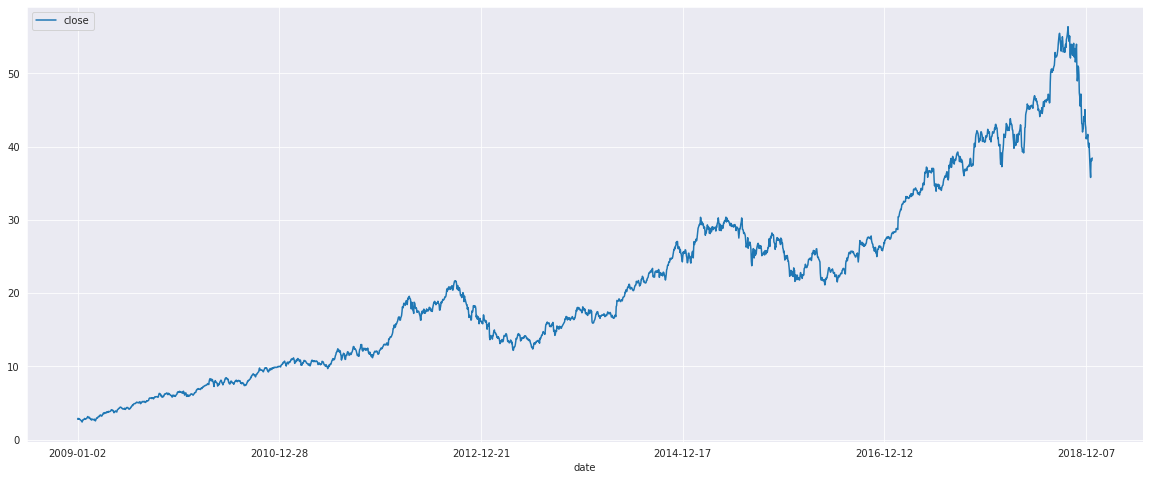

In [22]:
train.plot(x="date", y=["close"], 
        secondary_y=False,figsize=(20,8),grid=True).legend(loc='upper left')
plt.show()

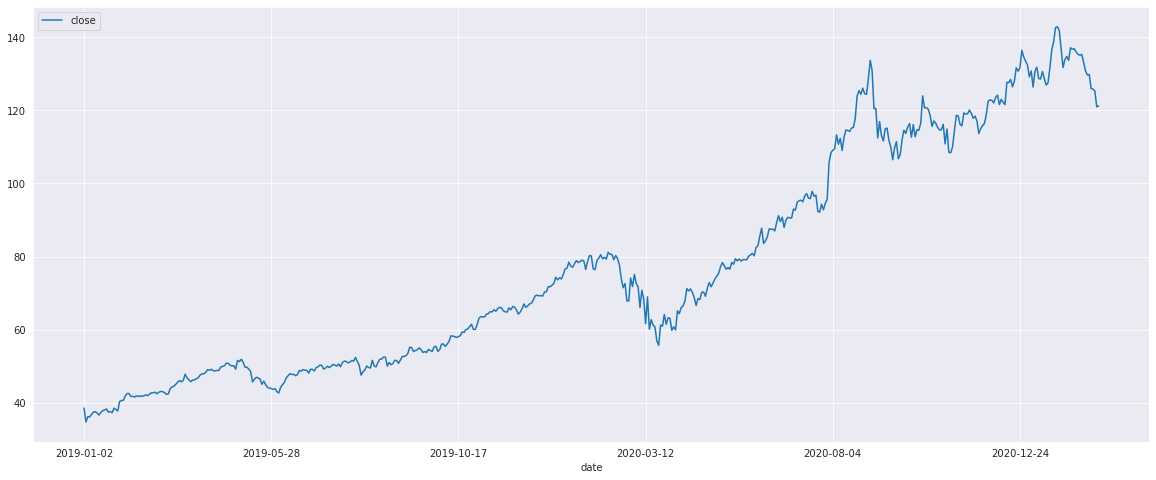

In [23]:
trade.plot(x="date", y=["close"], 
        secondary_y=False,figsize=(20,8),grid=True).legend(loc='upper left')
plt.show()

In [24]:
StockEnv_params = {
    'initial_account': 1000000,
    'df': train,
    'reward_low': 0.1,
    'reward_high' : 0.4,
    'reward_tipo' : 'spot' # 'mfi' ou 'spot'
}
# Instantiate the env
env1 = StockEnv(**StockEnv_params)
# If the environment don't follow the interface, an error will be thrown
check_env(env1, warn=True)

In [95]:
if not os.path.exists("./models"):
    os.makedirs("./models")

<a id='0'></a>
### Aprendizado de todos os Modelos X Todos os tipos de recompensa

In [88]:
for steps in [10000,40000,80000,100000]:
    for modelo in ['a2c', 'ddpg', 'td3', 'sac', 'ppo']:
        for recompensa in ['mfi','spot','rsi' ]:
            for reward_high in [0.1,0.25,0.5,0.75,1]:
                for reward_low in [-0.1,-0.25,-0.5,-0.75,-1]:
                    LearnModel(modelo,  # 'a2c', 'ddpg', 'td3', 'sac', 'ppo'
                               df = train ,
                               reward_low = reward_low ,
                               reward_high = reward_high , 
                               reward_tipo = recompensa, # 'mfi' ou 'spot' ou 'rsi' 
                               total_timesteps = steps) 
                    if recompensa == 'spot': # para recompensa spot não há necessidade de variar os valores low e high
                        break
                if recompensa == 'spot': # para recompensa spot não há necessidade de variar os valores low e high
                    break


Aprendizado modelo: a2c método de recompensa: mfi_low_-0.1_high_0.1_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.25_high_0.1_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.5_high_0.1_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.75_high_0.1_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-1_high_0.1_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.1_high_0.25_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.25_high_0.25_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.5_high_0.25_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mfi_low_-0.75_high_0.25_timesteps_10000
Num timesteps: 10000
Aprendizado modelo: a2c método de recompensa: mf

<a id='1'></a>
### Predição de todos os Modelos X Todos os tipos de recompensa

In [89]:
# Cálculo da estratégia de buy and hold
resultados = pd.DataFrame()
resultados['date'] = trade ['date']
qtde = 1e6 // (trade.loc[1,'close']*(1+1e-3)) # acrescenta os custos de compra
resultados['BuyHold'] = trade ['close']*qtde

In [92]:
for steps in [10000,40000,80000,100000]:
    for modelo in ['a2c', 'ddpg', 'td3', 'sac', 'ppo']:
        for recompensa in ['mfi','spot','rsi' ]:
            for reward_high in [0.1,0.25,0.5,0.75,1]:
                for reward_low in [-0.1,-0.25,-0.5,-0.75,-1]:
                    PredictModel(modelo, # 'a2c', 'ddpg', 'td3', 'sac', 'ppo'
                                 df = trade ,
                                 initial_account = 1e6 ,
                                 reward_low = reward_low ,  
                                 reward_high = reward_high , 
                                 reward_tipo = recompensa, # 'mfi' ou 'spot' ou 'rsi' 
                                 total_timesteps = steps) 
                    if recompensa == 'spot': # para recompensa spot não há necessidade de variar os valores low e high
                        break
                if recompensa == 'spot': # para recompensa spot não há necessidade de variar os valores low e high
                    break

Predição modelo: a2c método de recompensa: mfi_low_-0.1_high_0.1_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.25_high_0.1_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.5_high_0.1_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.75_high_0.1_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-1_high_0.1_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.1_high_0.25_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.25_high_0.25_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.5_high_0.25_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.75_high_0.25_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-1_high_0.25_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.1_high_0.5_timesteps_10000
Predição modelo: a2c método de recompensa: mfi_low_-0.25_high_0.5_timesteps_10000
Predição modelo: a2c m

In [96]:
if not os.path.exists("./resultados"):
    os.makedirs("./resultados")
resultados.to_pickle('./resultados/resultados.pkl') # salva o data frame resultados